### Імпортування бібліотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import netCDF4 as nc
from sklearn.linear_model import LinearRegression
import datetime 

### Перевірка застосування графічного процесора

In [2]:
#check if GPU is available
#print(tf.config.list_physical_devices('GPU'))

### Завантажження данних у словник

In [2]:

data = {
    year: {
            "climate": nc.Dataset("data/train/" + year + "/climate.nc"),
            "polution": nc.Dataset("data/train/" + year + "/polution.nc"),
        }
    for year in ["2021", "2022", "2023"]
}

#### Кількість географічних точок на кліматичних данних і на данних про викидів різниться. 
#### Знаходжу спільні точки

In [3]:
pol_lat_2021 = np.array(data["2021"]["polution"].variables["latitude"][: :-1])
climate_lat_2021 = np.array(data["2021"]["climate"].variables['lat'][:])
sorter = np.argsort(pol_lat_2021)
lats = -1 - np.searchsorted(pol_lat_2021, climate_lat_2021, sorter=sorter)


pol_lon_2021 = np.array(data["2021"]["polution"].variables["longitude"][:])
climate_lon_2021 = np.array(data["2021"]["climate"].variables['lon'][:])
sorter = np.argsort(pol_lon_2021)
lons = np.searchsorted(pol_lon_2021, climate_lon_2021, sorter=sorter)

### Завантаження данних у множину датафреймів

Одразу позбуваємось даних про вітер на висоті 50 метрів

In [4]:
start_date = datetime.date(2021, 1, 1); end_date = datetime.date(2023, 12, 31)
time = [start_date + datetime.timedelta(days=i) for i in range((end_date - start_date).days + 1)]

train_data = {}

atributes_climate = list(data["2021"]["climate"].variables.keys())[:-3]
atributes_climate.remove("WS50M")
atributes_climate.remove("WD50M")
atributes_polution = list(data["2021"]["polution"].variables.keys())[4:]

for i in range(len(lats)):
    for j in range(len(lons)):

        i_p = lats[i]
        j_p = lons[j]

        _data = {
            atribute: np.array(data["2021"]["climate"].variables[atribute][:, i, j])
            for atribute in atributes_climate
        }

        for atribute in atributes_polution:
            _data[atribute] = np.array(data["2021"]["polution"].variables[atribute][:, 0, i_p, j_p])


        _data["time"] = time

        for year in ["2022", "2023"]:
            for atribute in atributes_climate:
                _data[atribute] = np.append(_data[atribute], np.array(data[year]["climate"].variables[atribute][:, 0, 0]))
            for atribute in atributes_polution:
                _data[atribute] = np.append(_data[atribute], np.array(data[year]["polution"].variables[atribute][:, 0, 0, -1]))
        
        train_data[str(float(data["2021"]["climate"].variables["lat"][i])) + "x" + str(float(data["2021"]["climate"].variables["lon"][j]))]= pd.DataFrame(_data)


In [9]:
def norm(smth):
    smth = smth - np.min(smth)
    smth = smth/np.max(smth)
    return smth

def log_norm(smth):
    smth = np.log(1 + smth)
    return norm(smth)

In [10]:
sample = train_data["44.25x30.75"]
sample["co_conc"] = log_norm(sample["co_conc"])
sample["ALLSKY_SFC_SW_DWN"] = log_norm(sample["ALLSKY_SFC_SW_DWN"])
for i in atributes_climate:
    sample[i] = log_norm(sample[i])
sample.head()

,ALLSKY_SFC_SW_DWN,WD10M,QV2M,PS,WS10M,T2M,co_conc,no2_conc,no_conc,o3_conc,pm10_conc,pm2p5_conc,so2_conc,time
0,0.343741,0.885004,0.454919,0.567388,0.610355,0.694195,0.297221,2.526610,0.559673,51.689259,13.774988,8.790689,1.706610,2021-01-01
1,0.535560,0.822524,0.332772,0.760872,0.449125,0.664428,0.398022,0.953106,0.170985,60.666855,10.683568,7.786979,2.275357,2021-01-02
2,0.441665,0.699968,0.439985,0.742353,0.667446,0.673773,0.297877,0.590444,0.064119,73.790909,23.359228,7.605797,0.888747,2021-01-03
3,0.251281,0.706666,0.477366,0.651348,0.548200,0.671218,0.287901,0.792554,0.099135,74.386597,31.314342,16.264849,1.191523,2021-01-04
4,0.273353,0.810651,0.474516,0.548686,0.624359,0.687206,0.344157,2.439456,0.288225,63.343338,28.475145,18.588491,1.623917,2021-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,0.504557,0.907523,0.428538,0.643893,0.600576,0.671859,0.369335,1.973635,0.089216,56.505196,2.719846,2.470642,0.598573,2023-12-27
1091,0.466969,0.734391,0.301301,0.807091,0.499211,0.634175,0.445790,2.935729,0.263832,55.377506,6.573823,5.748918,1.993840,2023-12-28
1092,0.512973,0.898679,0.411348,0.666231,0.576074,0.650121,0.468065,2.816414,0.199975,43.828003,13.946591,11.377452,1.526470,2023-12-29
1093,0.399145,0.903820,0.387919,0.638311,0.417023,0.620460,0.471571,2.945606,0.128082,47.272038,13.147657,11.454666,1.440309,2023-12-30


In [19]:
params = sample.get(["ALLSKY_SFC_SW_DWN", "WD10M", "QV2M", "PS", "WS10M", "T2M", "co_conc"])
params["co_conc"] = sample["co_conc"].copy()
res = sample.get("co_conc")
temp = params["co_conc"][0]
for i in range(len(params["co_conc"]) - 1):
    _temp = params["co_conc"][i + 1]
    params["co_conc"][i+ 1] = temp
    temp = _temp
params

C:\Users\nickk\AppData\Local\Temp\ipykernel_15240\3886303474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["co_conc"] = sample["co_conc"].copy()
C:\Users\nickk\AppData\Local\Temp\ipykernel_15240\3886303474.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["co_conc"][i+ 1] = temp
C:\Users\nickk\AppData\Local\Temp\ipykernel_15240\3886303474.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

,ALLSKY_SFC_SW_DWN,WD10M,QV2M,PS,WS10M,T2M,co_conc
0,0.343741,0.885004,0.454919,0.567388,0.610355,0.694195,0.297221
1,0.535560,0.822524,0.332772,0.760872,0.449125,0.664428,0.297221
2,0.441665,0.699968,0.439985,0.742353,0.667446,0.673773,0.398022
3,0.251281,0.706666,0.477366,0.651348,0.548200,0.671218,0.297877
4,0.273353,0.810651,0.474516,0.548686,0.624359,0.687206,0.287901
...,...,...,...,...,...,...,...
1090,0.504557,0.907523,0.428538,0.643893,0.600576,0.671859,0.363551
1091,0.466969,0.734391,0.301301,0.807091,0.499211,0.634175,0.369335
1092,0.512973,0.898679,0.411348,0.666231,0.576074,0.650121,0.445790
1093,0.399145,0.903820,0.387919,0.638311,0.417023,0.620460,0.468065


In [20]:
model = LinearRegression().fit(params, res)

In [21]:
model.coef_

array([-0.05501312,  0.01288976, -0.01042321,  0.01069457, -0.01174153,
       -0.05534223,  0.681657  ], dtype=float32)

In [22]:
model.intercept_

0.1732265

In [18]:
model.coef_[0] * wind[-1] + model.coef_[1] * temp[-1] + model.intercept_

67.64603

In [21]:
model.predict([[wind[-1], temp[-1]]])

array([67.64603], dtype=float32)

In [23]:
prediction = np.array(model.predict(params))

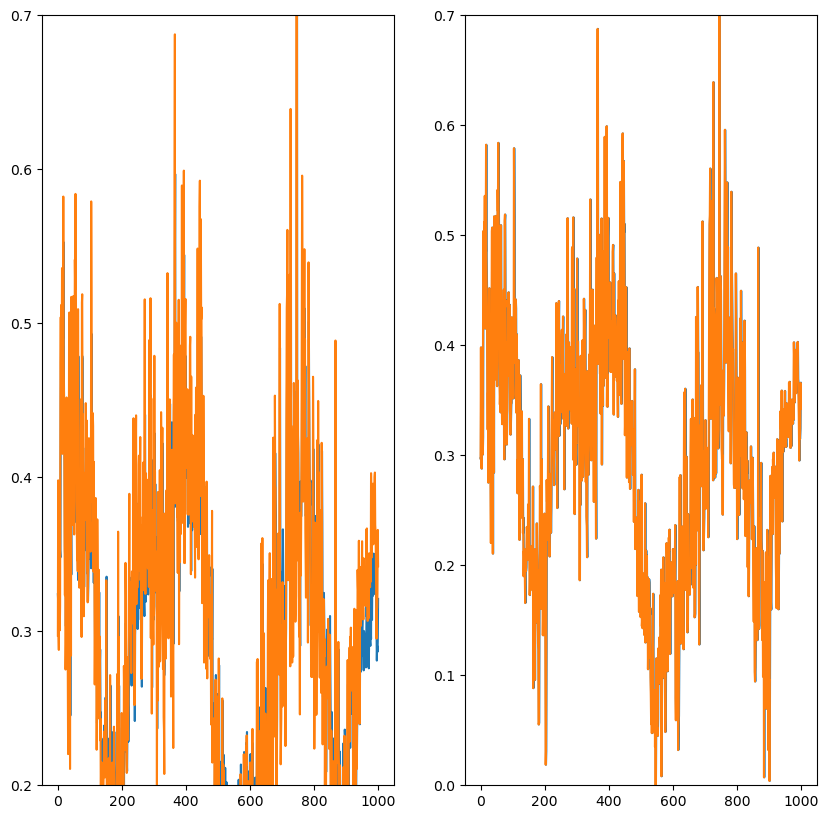

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10,10))
n = 1000
ax=axes[0]
ax.plot(prediction[:n])
ax.plot(res[:n])
ax.set_ylim([0.2, 0.7])

ax=axes[1]
ax.plot(params["co_conc"][:n])
ax.plot(res[:n])
ax.set_ylim([0, 0.7])

plt.show()

In [42]:
print("max difference = ", np.max(np.abs(prediction - res)), "=", np.max(np.abs(prediction - res)) / np.mean(np.abs(prediction - res)), "% "
      "mean difference = " ,np.mean(np.abs(prediction - res)), "=" , np.mean(np.abs(prediction - res)) / np.mean(np.abs(prediction - res)), "% ")

max difference =  0.5269701480865479 = 10.061551964868581 % mean difference =  0.05237464 = 1.0 % 


In [43]:
print("max difference = ", np.max(np.abs(params["co_conc"] - res)), "=", np.max(np.abs(params["co_conc"] - res)) / np.mean(np.abs(params["co_conc"] - res)), "% "
      "mean difference = " ,np.mean(np.abs(params["co_conc"] - res)), "=" , np.mean(np.abs(params["co_conc"] - res)) / np.mean(np.abs(params["co_conc"] - res)), "% ")

max difference =  0.6539776921272278 = 12.127930534736016 % mean difference =  0.05392327 = 1.0 % 


Kaggle

In [48]:
df = pd.read_csv('data/kaggle/onehr.data.xls')

In [18]:
df.columns = ["Date","WSR0","WSR1","WSR2","WSR3","WSR4","WSR5","WSR6","WSR7","WSR8","WSR9","WSR10","WSR11","WSR12","WSR13","WSR14","WSR15","WSR16","WSR17","WSR18","WSR19","WSR20","WSR21","WSR22","WSR23","WSR_PK","WSR_AV","T0","T1","T2","T3","T4","T5","T6","T7","T8","T9","T10","T11","T12","T13","T14","T15","T16","T17","T18","T19","T20","T21","T22","T23","T_PK","T_AV","T85","RH85","U85","V85","HT85","T70","RH70","U70","V70","HT70","T50","RH50","U50","V50","HT50","KI","TT","SLP","SLP_","Precp","Target"]

In [19]:
df

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,Target
0,1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,...,0.48,8.39,3.84,5805,14.05,29,10275,-55,0,0.0
1,1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,...,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0,0.0
2,1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,...,0.49,8.73,10.54,5775,31.15,51.7,10195,-40,2.08,0.0
3,1/5/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,...,?,?,?,?,?,?,?,?,0.58,0.0
4,1/6/1998,3.1,3.5,3.3,2.5,1.6,1.7,1.6,1.6,2.3,...,0.09,11.98,11.28,5770,27.95,46.25,10120,?,5.84,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,12/27/2004,0.3,0.4,0.5,0.5,0.2,0.3,0.4,0.4,1.3,...,0.07,7.93,-4.41,5800,-25.6,21.8,10295,65,0,0.0
2531,12/28/2004,1,1.4,1.1,1.7,1.5,1.7,1.8,1.5,2.1,...,0.04,5.95,-1.14,5845,-19.4,19.1,10310,15,0,0.0
2532,12/29/2004,0.8,0.8,1.2,0.9,0.4,0.6,0.8,1.1,1.5,...,0.06,7.8,-0.64,5845,-9.6,35.2,10275,-35,0,0.0
2533,12/30/2004,1.3,0.9,1.5,1.2,1.6,1.8,1.1,1,1.9,...,0.25,7.72,-0.89,5845,-19.6,34.2,10245,-30,0.05,0.0


In [20]:
data = nc.Dataset('data/2/adaptor.cams_regional_fc.retrieve-1706511910.699155-19398-7-0139e086-561b-430a-ad16-805bf0c3497a.nc')

In [21]:
data.variables.keys()

dict_keys(['longitude', 'latitude', 'level', 'time', 'o3_conc'])

In [22]:
data['o3_conc']

<class 'netCDF4._netCDF4.Variable'>
float32 o3_conc(time, level, latitude, longitude)
    _FillValue: -999.0
    species: Ozone
    units: µg/m3
    value: hourly values
    standard_name: mass_concentration_of_ozone_in_air
unlimited dimensions: time
current shape = (1, 10, 3, 3)
filling on

In [23]:
data['latitude']

<class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    long_name: latitude
    units: degrees_north
unlimited dimensions: 
current shape = (3,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [24]:
data['level']

<class 'netCDF4._netCDF4.Variable'>
float32 level(level)
    long_name: level
    units: m
unlimited dimensions: 
current shape = (10,)
filling on, default _FillValue of 9.969209968386869e+36 used